In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.cluster import DBSCAN, HDBSCAN

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import SaltRemover as sr
remover = sr.SaltRemover()

In [4]:
df1 = pd.read_csv('final_total.csv', sep=' ', na_values=['na'])
df1 = df1.dropna(ignore_index=True)

In [5]:
df1.loc[:, 'ido_ic50'] = (np.log10((df1.loc[:, 'ido_ic50'])*10**(-9)))*(-1)
df1.loc[:, 'tdo_ic50'] = (np.log10((df1.loc[:, 'tdo_ic50'])*10**(-9)))*(-1)

In [6]:
df2 = df1.loc[:, ['ido_ic50', 'tdo_ic50']]

In [7]:
for i in range(len(df2)):
    if df2['ido_ic50'].values[i] >= 6.15:
        df2.loc[i, ['ido_ic50']] = 1
    else:
        df2.loc[i, ['ido_ic50']] = 0

In [8]:
for i in range(len(df2)):
    if df2['tdo_ic50'].values[i] >= 6.0:
        df2.loc[i, ['tdo_ic50']] = 1
    else:
        df2.loc[i, ['tdo_ic50']] = 0

In [9]:
newcol = []
for i in range(len(df2)):
    if df2['ido_ic50'].values[i] == 1.0 and df2['tdo_ic50'].values[i] == 1.0:
        newcol.append('AA')
    elif df2['ido_ic50'].values[i] == 0.0 and df2['tdo_ic50'].values[i] == 0.0:
        newcol.append('II')
    elif df2['ido_ic50'].values[i] == 0.0 and df2['tdo_ic50'].values[i] == 1.0:
        newcol.append('IA')
    else:
        newcol.append('AI')

In [10]:
target = pd.DataFrame(data=newcol, columns=['ido_tdo'])

In [11]:
encoder = LabelEncoder()
y_label = encoder.fit_transform(target['ido_tdo'])

In [12]:
mols = []
for i in range(len(df1)):
    try:
        mol_i = Chem.MolFromSmiles(df1['smiles'][i])
        if mol_i is None:
            print(f"[WARNING] Invalid SMILES at index {i}, skipping.")
            mols.append(None)  # Maintain indexing for multiprocessing
            continue
        mol_i = remover.StripMol(mol_i, dontRemoveEverything=True)
        mols.append(mol_i)
    except Exception as e:
        print(e)
len(mols)

760

In [13]:
#Morgan Fingerprints:
fpgen2 = AllChem.GetMorganGenerator(fpSize=1024)
i = 0
l2 = np.zeros((1, 1024), dtype='uint8')
for mol in mols:
    fp2 = fpgen2.GetFingerprintAsNumPy(mols[i])
    l2 = np.vstack((l2, fp2))
    i += 1
MFPs = l2[1:, :]
MFPs.shape

(760, 1024)

In [14]:
FP_df = pd.DataFrame(MFPs)

In [15]:
x = FP_df.values

In [16]:
from sklearn.manifold import TSNE

In [17]:
tsne = TSNE(n_components=2, random_state=42)

In [18]:
reduced_data_tsne = tsne.fit_transform(x)

In [19]:
#with dimension reduction:
hdb = HDBSCAN(min_cluster_size=10, min_samples=10).fit(reduced_data_tsne)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_clusters(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))

    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])

    unique_labels = sorted(set(labels))
    cmap = plt.colormaps.get_cmap("tab20")  # modern API, no extra argument

    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}

    for k in unique_labels:
        if k == -1:
            # Black for noise
            col = (0, 0, 0, 1)
            marker = "x"
            cluster_name = "Noise"
        else:
            # Cycle through colormap if clusters > 20
            col = cmap(k % cmap.N)
            marker = "o"
            cluster_name = f"Cluster {k}"

        class_index = np.where(labels == k)[0]
        sizes = [30 if k == -1 else 50 + 100 * proba_map[ci] for ci in class_index]

        if marker == "x":
            ax.scatter(
                X[class_index, 0],
                X[class_index, 1],
                c=[col],
                s=sizes,
                marker=marker,
                facecolor=col,   # avoid edgecolor warning
                label=cluster_name,
                alpha=0.8
            )
        else:
            ax.scatter(
                X[class_index, 0],
                X[class_index, 1],
                c=[col],
                s=sizes,
                marker=marker,
                edgecolor="k",
                linewidth=0.5,
                label=cluster_name,
                alpha=0.8
            )

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title, fontsize=14)

    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10, frameon=True)
    ax.set_xlabel("t-SNE 1", fontsize=12)
    ax.set_ylabel("t-SNE 2", fontsize=12)
    plt.tight_layout()


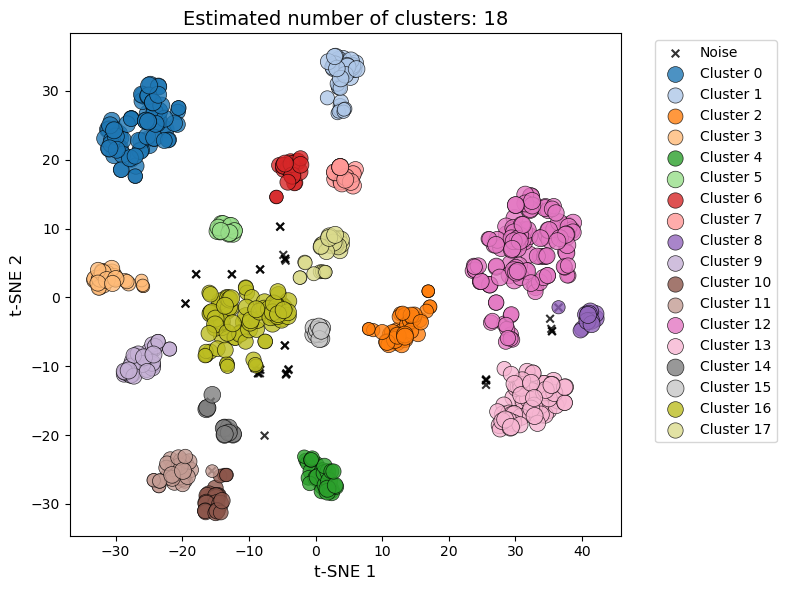

In [21]:
plot_clusters(reduced_data_tsne, hdb.labels_, hdb.probabilities_)
plt.show()

In [22]:
#hdb.labels_

In [23]:
#sorted(set(hdb.labels_))

In [24]:
#hdb.probabilities_

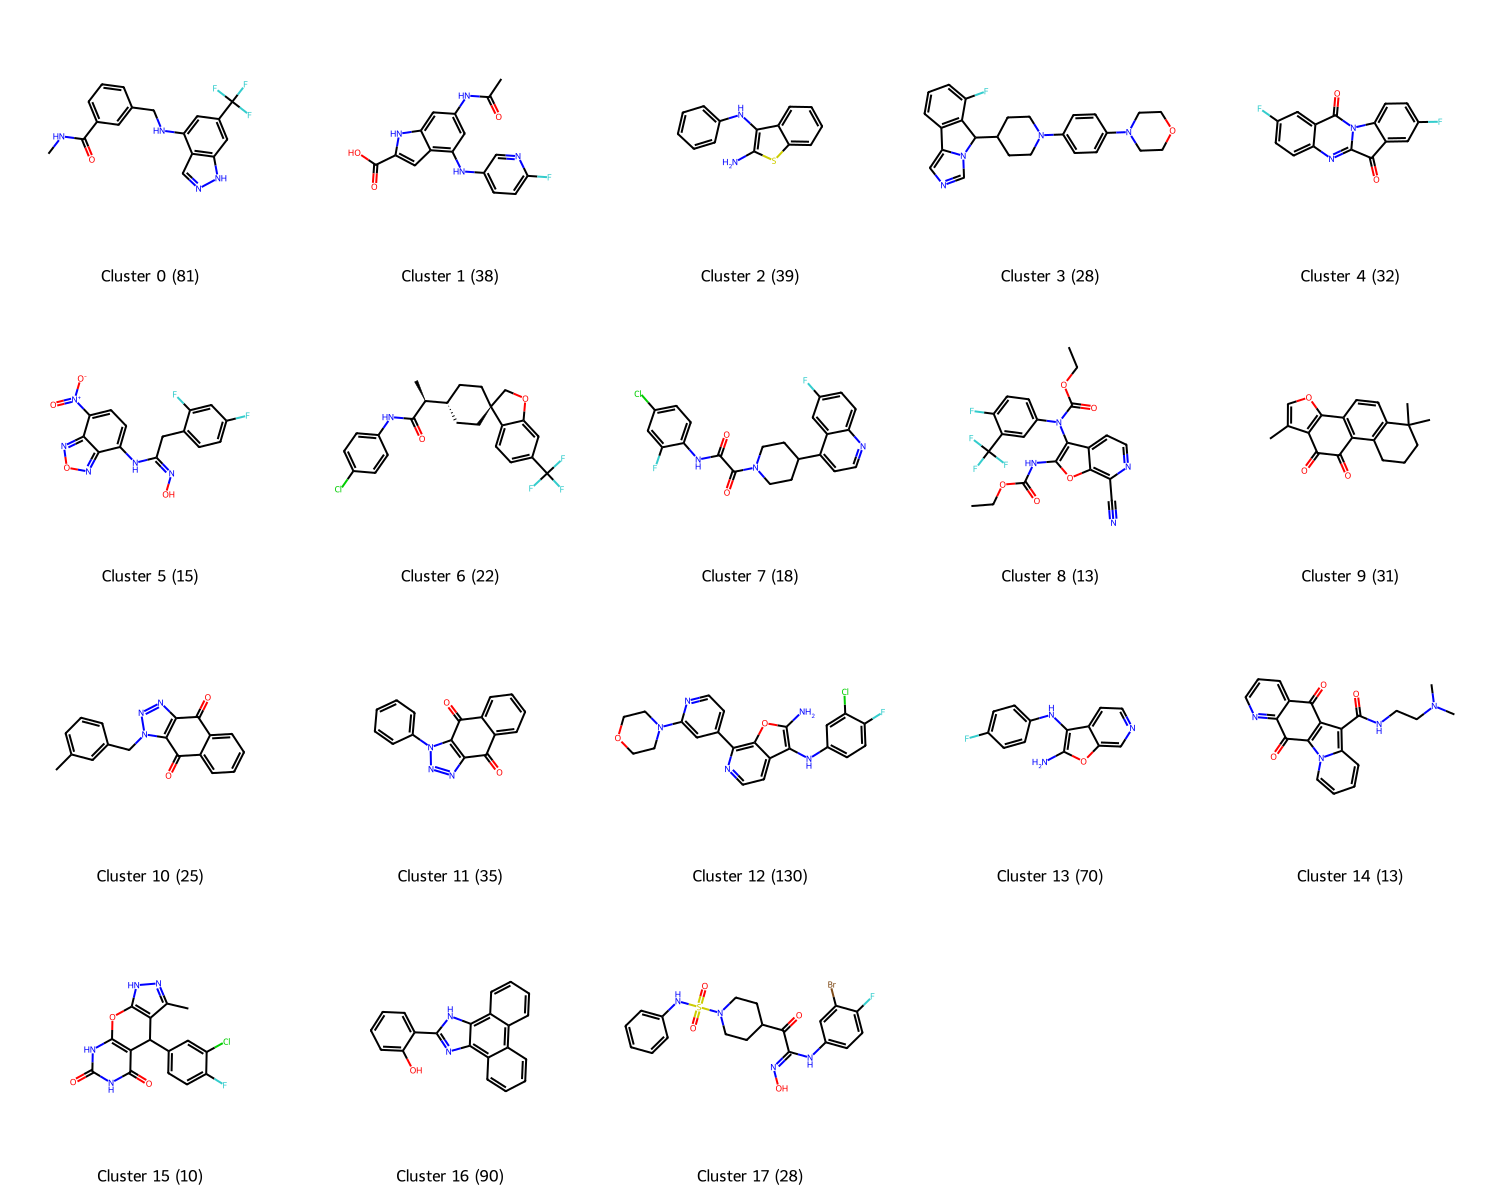

In [25]:
from rdkit.Chem import Draw

# --- Step 1: Collect representative indices per cluster ---
cluster_labels = hdb.labels_
unique_clusters = sorted(set(cluster_labels))
representatives = {}

for cl in unique_clusters:
    if cl == -1:
        continue  # skip noise cluster
    # indices of molecules in this cluster
    indices = np.where(cluster_labels == cl)[0]
    if len(indices) == 0:
        continue
    # pick the molecule with highest probability in this cluster
    best_idx = indices[np.argmax(hdb.probabilities_[indices])]
    representatives[cl] = best_idx

# --- Step 2: Extract representative molecules ---
rep_mols = []
rep_labels = []
for cl, idx in representatives.items():
    if mols[idx] is not None:
        rep_mols.append(mols[idx])
        cluster_size = np.sum(cluster_labels == cl)   # number of members in cluster
        rep_labels.append(f"Cluster {cl} ({cluster_size})")

# --- Step 3: Visualize representatives ---
img = Draw.MolsToGridImage(
    rep_mols,
    molsPerRow=5,
    subImgSize=(300,300),
    legends=rep_labels
)

img   # Jupyter will render inline

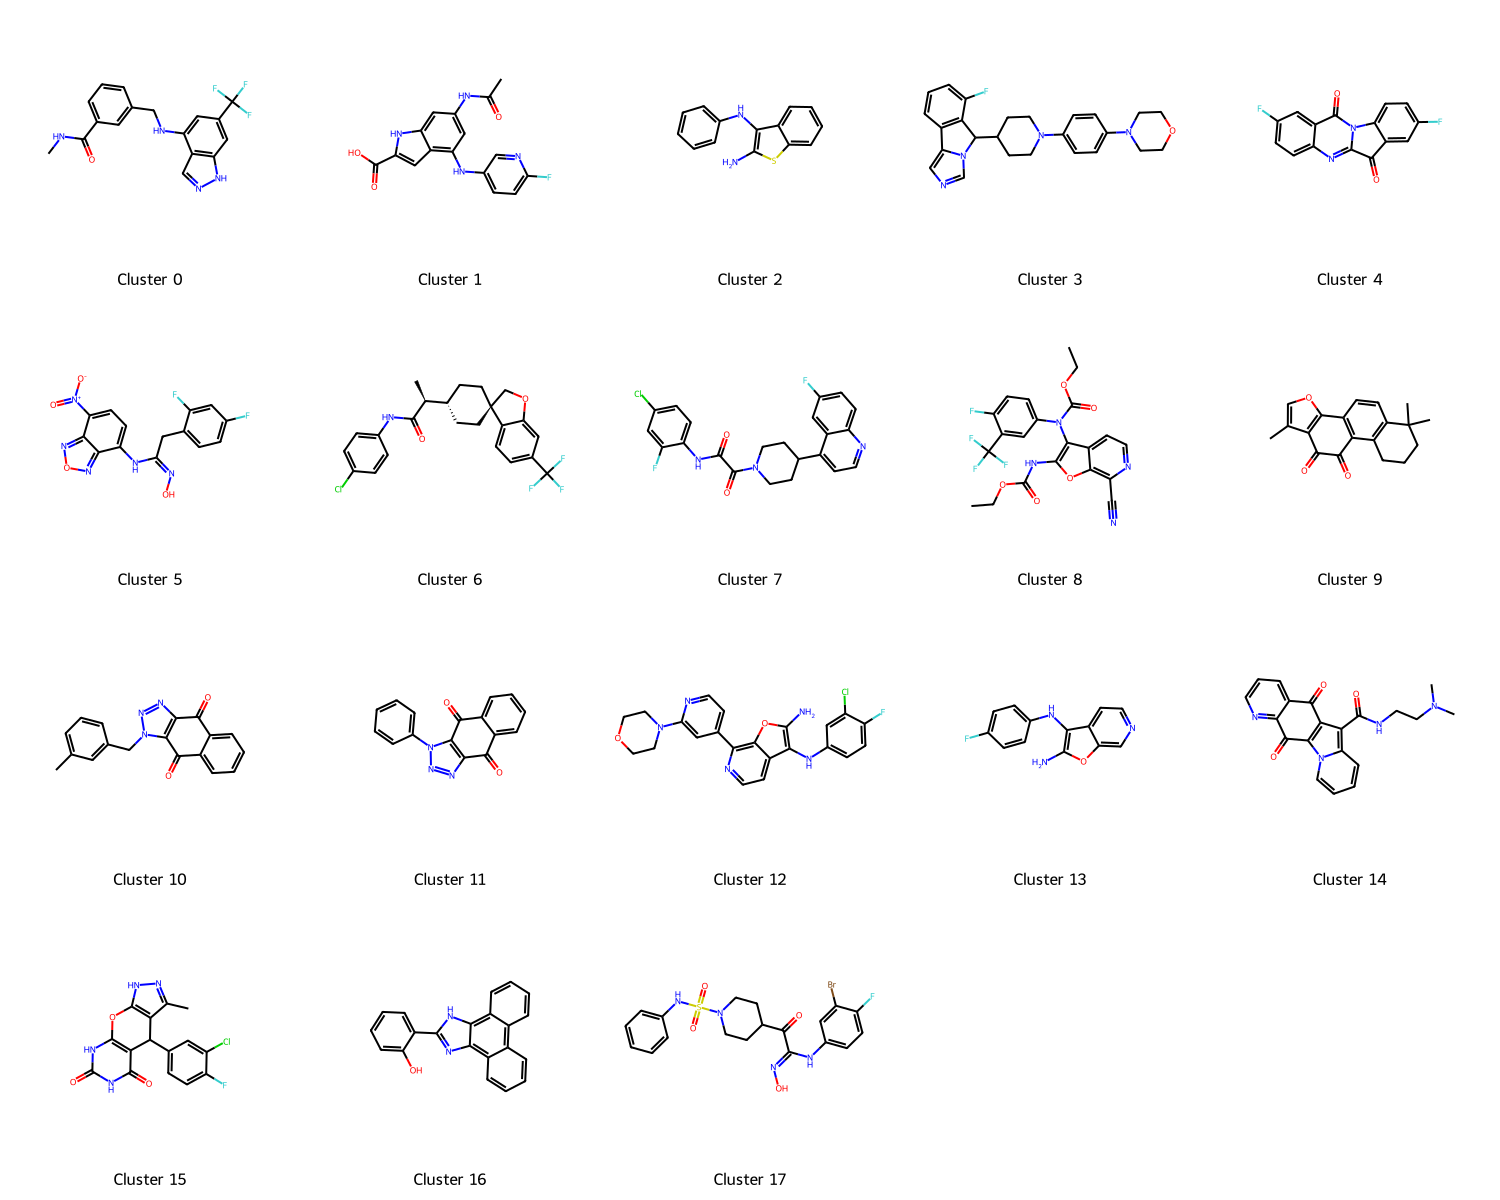

In [26]:
from rdkit.Chem import Draw

# --- Step 1: Collect representative indices per cluster ---
cluster_labels = hdb.labels_
unique_clusters = sorted(set(cluster_labels))
representatives = {}

for cl in unique_clusters:
    if cl == -1:
        continue  # skip noise cluster
    # pick the molecule with highest probability in this cluster
    indices = np.where(cluster_labels == cl)[0]
    if len(indices) == 0:
        continue
    # sort by probability descending
    best_idx = indices[np.argmax(hdb.probabilities_[indices])]
    representatives[cl] = best_idx

# --- Step 2: Extract representative molecules ---
rep_mols = [mols[idx] for idx in representatives.values() if mols[idx] is not None]
rep_labels = [f"Cluster {cl}" for cl in representatives.keys()]

# --- Step 3: Visualize representatives ---
img = Draw.MolsToGridImage(rep_mols, molsPerRow=5, subImgSize=(300,300), legends=rep_labels, returnPNG=True)
img

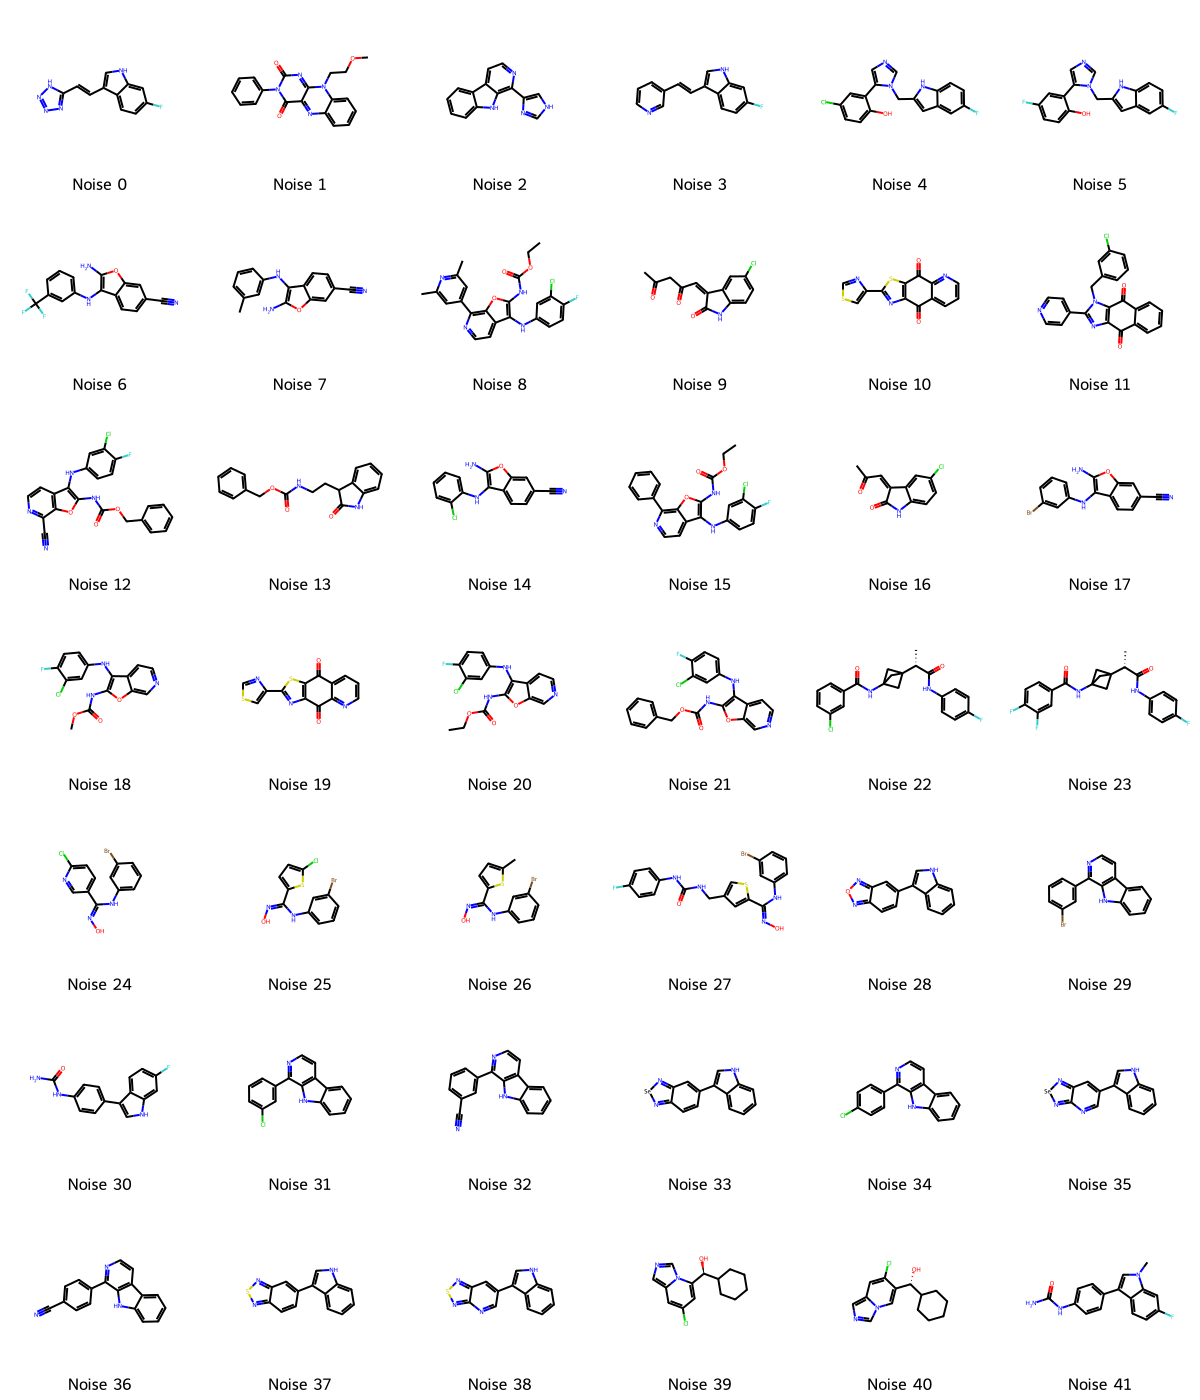

In [117]:
from rdkit.Chem import Draw

# --- Step 1: Find indices of noise molecules ---
noise_indices = np.where(hdb.labels_ == -1)[0]

# --- Step 2: Collect noise molecules ---
noise_mols = [mols[idx] for idx in noise_indices if mols[idx] is not None]
noise_labels = [f"Noise {i}" for i in range(len(noise_mols))]

# --- Step 3: Visualize them in a grid ---
img_noise = Draw.MolsToGridImage(
    noise_mols,
    molsPerRow=6,          # 4 molecules per row
    subImgSize=(200,200),  # size of each molecule image
    legends=noise_labels,
    returnPNG=True
)

img_noise   # Jupyter will render inline

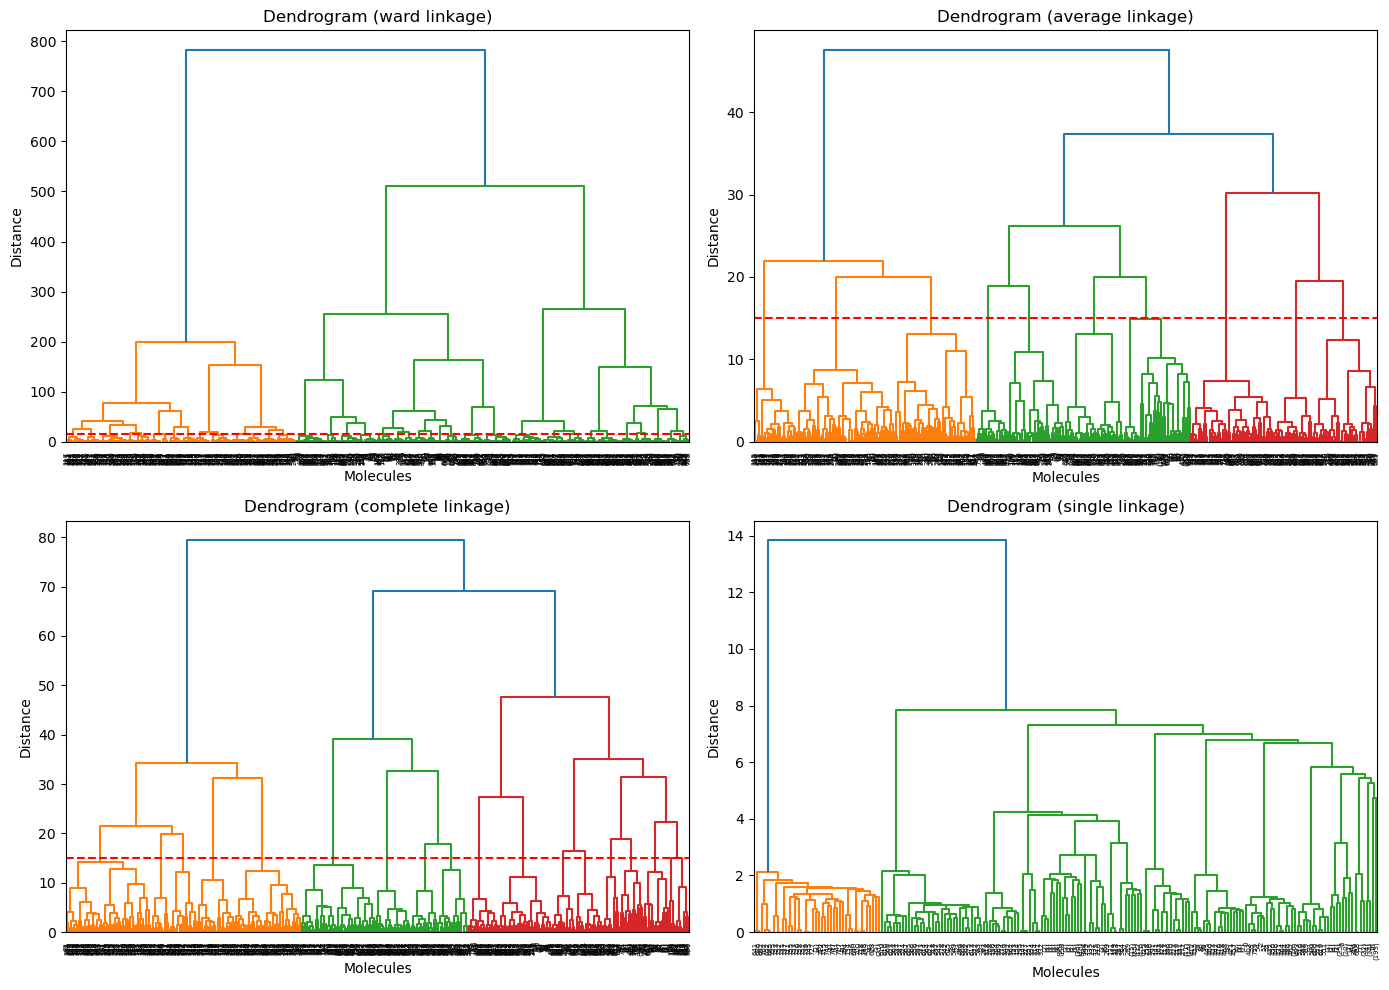

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# --- Step 1: Assume you already have your t-SNE reduced data ---
# X_tsne is a numpy array of shape (760, 2)
# Example: X_tsne = np.load("tsne_data.npy")

X = reduced_data_tsne

# --- Step 2: Define linkage methods ---
linkage_methods = ["ward", "average", "complete", "single"]

# --- Step 3: Set cut-off threshold ---
cutoff = 15.0  # adjust based on your dataset

# --- Step 4: Plot dendrograms with cut-off line ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, method in enumerate(linkage_methods):
    linked = linkage(X, method=method)
    dendrogram(linked, ax=axes[i], truncate_mode="level", p=10)
    axes[i].axhline(y=cutoff, color='red', linestyle='--')
    axes[i].set_title(f"Dendrogram ({method} linkage)")
    axes[i].set_xlabel("Molecules")
    axes[i].set_ylabel("Distance")

plt.tight_layout()
plt.show()


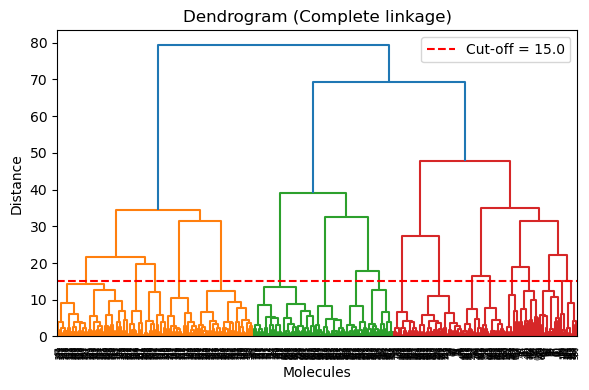

In [112]:

# --- Step 1: Assume you already have your t-SNE reduced data ---
# X_tsne is a numpy array of shape (760, 2)
# Example: X_tsne = np.load("tsne_data.npy")

X = reduced_data_tsne

# --- Step 2: Set cut-off threshold ---
cutoff = 15.0  # adjust based on your dataset

# --- Step 3: Perform complete linkage and plot dendrogram ---
linked = linkage(X, method="complete")

plt.figure(figsize=(6, 4))
dendrogram(linked, truncate_mode="level", p=10)
plt.axhline(y=cutoff, color="red", linestyle="--", label=f"Cut-off = {cutoff}")
plt.title("Dendrogram (Complete linkage)")
plt.xlabel("Molecules")
plt.ylabel("Distance")
plt.legend()
plt.tight_layout()
plt.show()